## 1. Configuración Inicial y Banderas

In [1]:
# Banderas para habilitar mejoras
USE_HSV = True            # Convertir al espacio de color HSV
USE_TEXTURE = True        # Incluir características de textura (LBP)
USE_KERNEL = True         # Usar SVM con kernel no lineal (RBF)
USE_VALIDATION = True     # Realizar validación y calcular métricas
MULTICLASS = True         # Realizar clasificación multiclase (One-vs-All)

## 2. Importar Librerías Necesarias

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2  # OpenCV para conversión de espacios de color
from skimage.feature import local_binary_pattern
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

## 3. Funciones Auxiliares

### 3.1. Conversión de Espacio de Color

In [4]:
def convert_color_space(image_array):
    if USE_HSV:
        return cv2.cvtColor(image_array, cv2.COLOR_RGB2HSV)
    else:
        return image_array  # Mantener en RGB

### 3.2. Extracción de Características de Textura

In [5]:
def extract_texture_features(image_array):
    if USE_TEXTURE:
        # Parámetros para LBP
        radius = 1
        n_points = 8 * radius
        # Convertir a escala de grises
        image_gray = cv2.cvtColor(image_array, cv2.COLOR_RGB2GRAY)
        # Calcular LBP
        lbp = local_binary_pattern(image_gray, n_points, radius, method='uniform')
        # Normalizar LBP
        lbp_normalized = lbp / np.max(lbp)
        return lbp_normalized.reshape(-1, 1)
    else:
        return None

### 3.3. Preparación de Datos

In [6]:
def prepare_data(images, labels):
    feature_list = []
    label_list = []
    
    for image_path, label in zip(images, labels):
        image = Image.open(image_path)
        image_array = np.array(image)
        
        # Conversión de espacio de color
        image_array = convert_color_space(image_array)
        
        # Extraer características de color
        X_color = image_array.reshape(-1, 3) / 255.0  # Normalizar
        
        # Extraer características de textura
        X_texture = extract_texture_features(np.array(image))
        
        # Concatenar características si se usa textura
        if USE_TEXTURE and X_texture is not None:
            X = np.hstack((X_color, X_texture))
        else:
            X = X_color
        
        feature_list.append(X)
        label_list.append(np.full(X.shape[0], label))
    
    # Combinar todas las características y etiquetas
    X_combined = np.vstack(feature_list)
    y_combined = np.hstack(label_list)
    
    return X_combined, y_combined

## 4. Preparación del Conjunto de Datos

### 4.1. Definir Rutas de las Imágenes y Etiquetas

In [8]:
if MULTICLASS:
    # Para clasificación multiclase
    image_paths = ['../images/train/vaca.jpg', '../images/train/pasto.jpg', '../images/train/cielo.jpg']
    labels = [0, 1, 2]  # 0: vaca, 1: pasto, 2: cielo
else:
    # Para clasificación binaria
    image_paths = ['../images/train/vaca.jpg', '../images/train/pasto.jpg', '../images/train/cielo.jpg']
    labels = [1, -1, -1]  # 1: vaca, -1: no vaca

### 4.2. Preparar los Datos de Entrenamiento

In [9]:
X_train, y_train = prepare_data(image_paths, labels)

## 5. Entrenamiento del Modelo

### 5.1. Dividir Datos para Validación

In [11]:
if USE_VALIDATION:
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42)
else:
    X_train_split, y_train_split = X_train, y_train

### 5.2. Entrenar el Modelo

In [12]:
if USE_KERNEL:
    kernel_type = 'rbf'
else:
    kernel_type = 'linear'

In [13]:
if MULTICLASS:
    clf = svm.SVC(kernel=kernel_type, C=1.0, gamma='scale', decision_function_shape='ovr')
    clf.fit(X_train_split, y_train_split)
else:
    # Clasificación binaria 'vaca' vs. 'no vaca'
    clf = svm.SVC(kernel=kernel_type, C=1.0, gamma='scale')
    clf.fit(X_train_split, y_train_split)

## 6. Evaluación del Modelo

In [14]:
if USE_VALIDATION:
    y_val_pred = clf.predict(X_val_split)
    
    accuracy = accuracy_score(y_val_split, y_val_pred)
    precision = precision_score(y_val_split, y_val_pred, average='weighted')
    recall = recall_score(y_val_split, y_val_pred, average='weighted')
    f1 = f1_score(y_val_split, y_val_pred, average='weighted')
    
    print("Métricas de Rendimiento en el Conjunto de Validación:")
    print(f"Precisión (Accuracy): {accuracy:.4f}")
    print(f"Precisión (Precision): {precision:.4f}")
    print(f"Exhaustividad (Recall): {recall:.4f}")
    print(f"Puntuación F1: {f1:.4f}")

Métricas de Rendimiento en el Conjunto de Validación:
Precisión (Accuracy): 0.9874
Precisión (Precision): 0.9874
Exhaustividad (Recall): 0.9874
Puntuación F1: 0.9874


## 7. Clasificación de la Imagen Compuesta

### 7.1. Preparar los Datos de la Imagen Compuesta

In [16]:
# Cargar la imagen compuesta
composite_image = Image.open('../images/cow.jpg')
composite_array = np.array(composite_image)

# Conversión de espacio de color
composite_array = convert_color_space(composite_array)

# Extraer características de color
X_test_color = composite_array.reshape(-1, 3) / 255.0

# Extraer características de textura
X_test_texture = extract_texture_features(np.array(composite_image))

# Concatenar características si se usa textura
if USE_TEXTURE and X_test_texture is not None:
    X_test = np.hstack((X_test_color, X_test_texture))
else:
    X_test = X_test_color

In [17]:
y_pred = clf.predict(X_test)

## 8. Generar la Imagen de Segmentación

### 8.1. Reconstruir la Imagen de Predicciones

In [18]:
height, width = composite_image.size
y_pred_image = y_pred.reshape(width, height).T  # Transponer para ajustar dimensiones

### 8.2. Mapear Colores a las Clases

In [19]:
if not MULTICLASS:
    mask = np.zeros((height, width), dtype=np.uint8)
    mask[y_pred_image == 1] = 255  # Clase 'vaca' en blanco
else:
    # Mapear cada clase a un color
    color_map = {
        0: [255, 0, 0],   # Rojo para 'vaca'
        1: [0, 255, 0],   # Verde para 'pasto'
        2: [0, 0, 255]    # Azul para 'cielo'
    }
    segmented_image = np.zeros((height, width, 3), dtype=np.uint8)
    for cls, color in color_map.items():
        segmented_image[y_pred_image == cls] = color

## 9. Visualización de Resultados

### 9.1. Mostrar la Imagen Original y la Segmentación

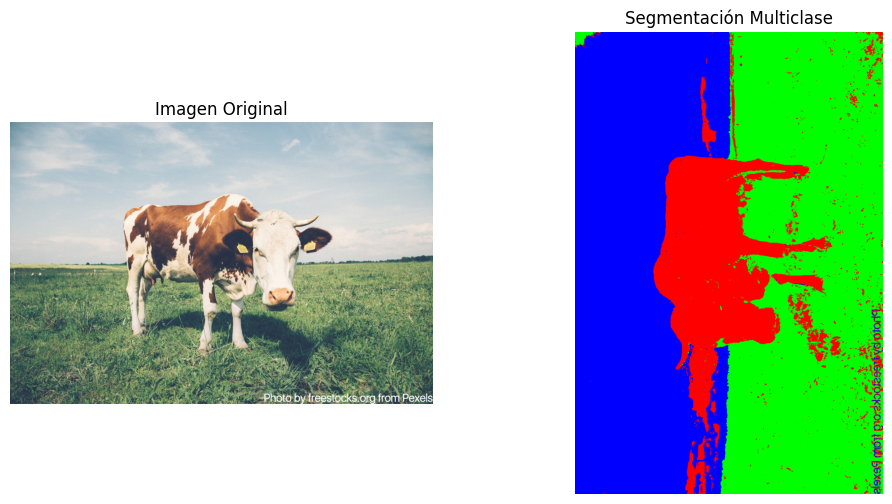

In [21]:
if not MULTICLASS:
    mask_image = Image.fromarray(mask)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(composite_image)
    plt.title('Imagen Original')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask_image, cmap='gray')
    plt.title('Segmentación (Vaca vs. No Vaca)')
    plt.axis('off')
    
    plt.show()
else:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(composite_image)
    plt.title('Imagen Original')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(segmented_image)
    plt.title('Segmentación Multiclase')
    plt.axis('off')
    
    plt.show()